In [1]:
%run include/utils.py
%matplotlib inline 

In [2]:
from sklearn import datasets, linear_model, svm

### Data Sets 

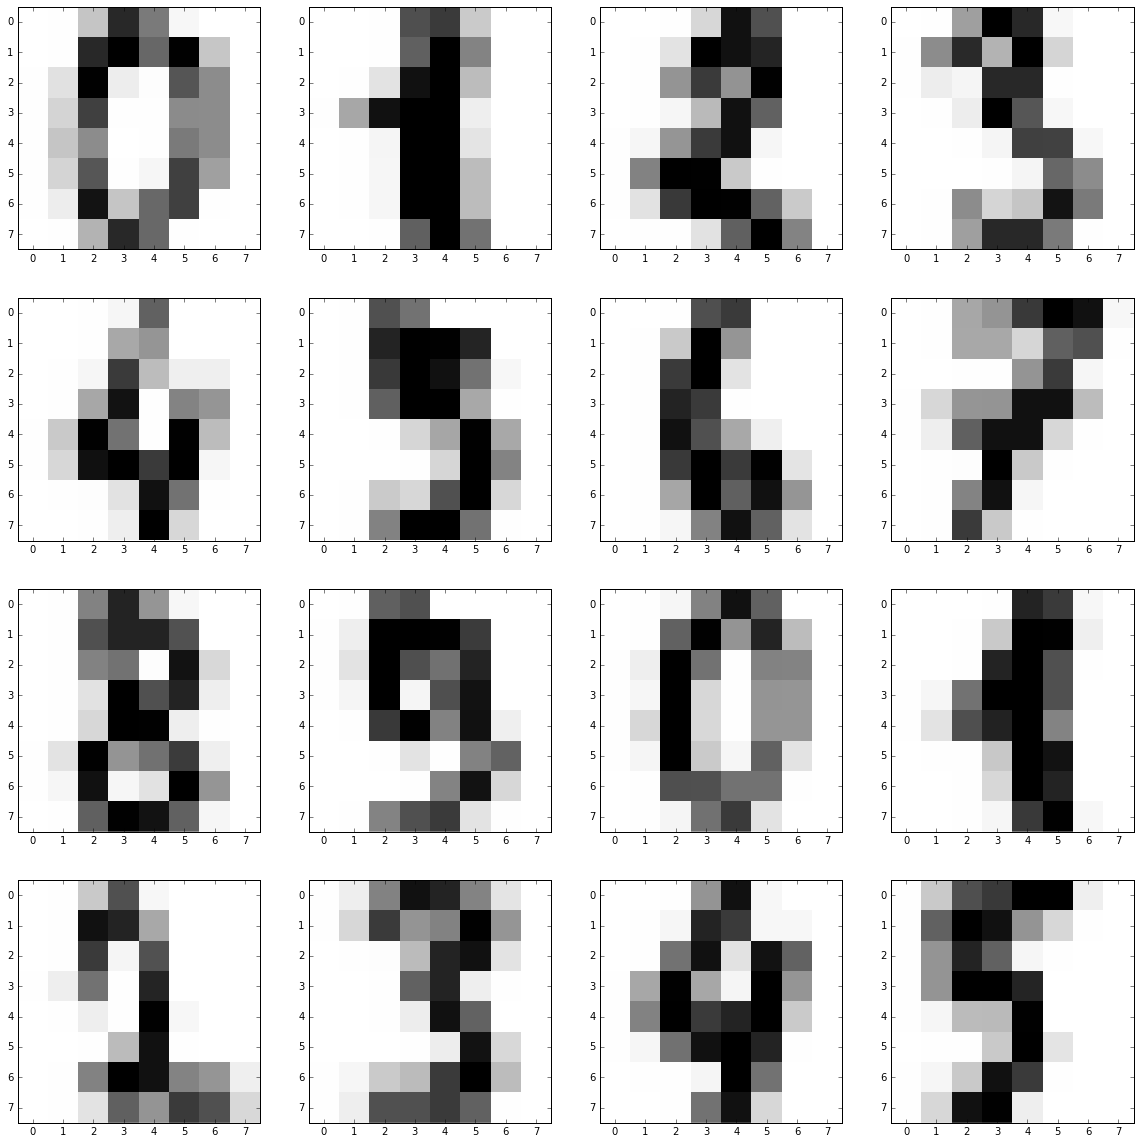

In [3]:
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

plt.figure(figsize=(20,20))
for i in range(16):
    M = X_digits[i,:].reshape((8,8))
    plt.subplot(4,4,i+1) 
    plt.imshow(M, interpolation='none', vmax=np.max(M), vmin=0, aspect='auto', cmap='Greys')

In [4]:
# cluster centers and respective variances
def gen_data(N1=50, N2=50, N_outlier=0, draw=False):
    center1 = np.array([4,6])
    center2 = np.array([6,4])
    outlier_center = np.array([9,2])
    var1 = np.array([1,3])
    var2 = np.array([3,1])
    var_outlier = np.array([0.5,0.5])

    # data stay in rows
    S1 = np.tile(center1.reshape((-1,1)),N1).transpose() + np.random.random((N1,len(center1)))*var1
    S2 = np.tile(center2.reshape((-1,1)),N2).transpose() + np.random.random((N2,len(center2)))*var2
    outliers = np.tile(outlier_center.reshape((-1,1)),N_outlier).transpose() + np.random.random((N_outlier,2))*var_outlier
    N2 += N_outlier
    S2 = np.vstack((S2,outliers))

    X = np.vstack((S1,S2))
    R = np.hstack((np.zeros(len(S1)),np.ones(len(S2))))
    if draw:
        draw_points(X, N1, [0,10], [0,10])
    
    return X, R, N1, N2


def gen_data_gauss(N11=50, N12=50, N2=50, draw=False,
                  center11 = np.array([2,8]),
                  center12 = np.array([5,5]),
                  center2 = np.array([8,2]),
                  var11 = np.array([1.2,1,1,1.2]).reshape((2,2)),
                  var12 = np.array([1.2,1,1,1.2]).reshape((2,2)),
                  var2 = np.array([1.0,1,1,1.0]).reshape((2,2))):
    # data stay in rows
    S11 = np.random.multivariate_normal(center11,var11,(N11))
    S12 = np.random.multivariate_normal(center12,var12,(N12))
    S2 = np.random.multivariate_normal(center2,var2,(N2))
    S1 = np.vstack((S11,S12))
    N1 = N11+N12
    # data matrix
    X = np.vstack((S1,S2))
    R = np.hstack((np.zeros(len(S1)),np.ones(len(S2))))
    if draw:
        draw_points(X, N1, [-2,12], [-2,12], title_="data points")
    return X, R, N1, N2


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
def plot_matrix(X, title='Title', xlabel='xlabel', ylabel='ylabel', figsize=None):
    if figsize is None:
        plt.figure(figsize=(25,6))
    else:
        plt.figure(figsize=figsize)
    plt.imshow(X, interpolation='none', vmax=np.max(X), vmin=0, aspect='auto')
    plt.colorbar()
    plt.set_cmap('gray_r')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)


# W[0] + x*W[1] + y*W[2] = 0
def plot_line(X,W):
    x_ = np.arange(np.min(X),np.max(X),1e-2)
    y_ = (-x_*W[1]-W[0])/W[2]
    plt.plot(x_, y_, 'b-')
    
    
def draw_points(X, N1, xlim_, ylim_, title_='', W=None):
    plt.figure()
    plt.plot(X[:N1,0],X[:N1,1], 'b+')
    plt.plot(X[N1:,0],X[N1:,1], 'r*')
    plt.title(title_)
    plt.xlim(xlim_)
    plt.ylim(ylim_)
    
    # W[0] + x*W[1] + y*W[2] = 0
    if W is not None:
        plot_line(X,W)

### Ordinary Least Squares

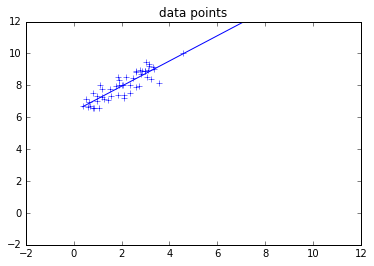

In [6]:
X,R,N1,N2 = gen_data_gauss(N11=50, N12=0, N2=0, draw=True, center12=np.array([5,8]), var11 = np.array([1.1,1,1,1.1]).reshape((2,2)))
reg = linear_model.LinearRegression()
W = reg.fit(X[:,0].reshape((-1,1)),X[:,1].reshape((-1,1)))
plot_line(X,[-W.intercept_[0],-W.coef_[0][0],1])

### Logistic Regression

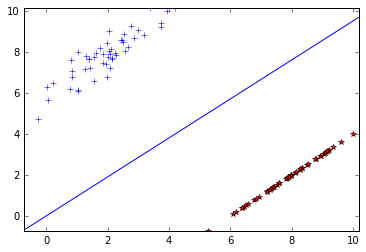

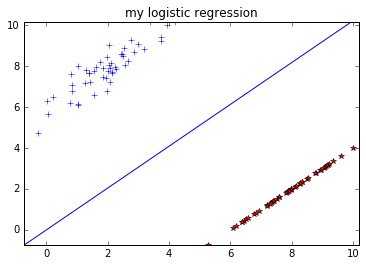

In [7]:
X,R,N1,N2 = gen_data_gauss(N11=50, N12=0, N2=50,
                           center11 = np.array([2,8]),
                           center12 = np.array([5,5]),
                           center2 = np.array([8,2]))
# print(np.hstack((R.reshape((-1,1)),X)))
log_reg = linear_model.LogisticRegression(penalty="l1", max_iter=100)
W = log_reg.fit(X,R)
draw_points(X,N1,[np.min(X), np.max(X)],[np.min(X), np.max(X)],W=[-W.intercept_[0],-W.coef_[0][0],1])

def batch_log_reg(phi, N1, draw=False, epoch_=100, eta=0.1):
    phi_ = np.hstack((np.ones((phi.shape[0],1)),phi))
    N2 = phi.shape[0]-N1
    R = np.hstack((np.zeros(N1),np.ones(N2)))
    W = np.random.random(3)*1e-2
    for i in range(epoch_):
        err = R - sigmoid(np.dot(phi_,W))
        grad = np.sum(np.tile(err.reshape((-1,1)),(1,3))*phi_, axis=0)
        W += eta*grad
        if draw:
            draw_points(phi, N1, [np.min(phi),np.max(phi)], [np.min(phi),np.max(phi)], title_="batch logistic regression at iteration"+str(i), W=W_)
    return W

def stoch_log_reg(phi, N1, draw=False, epoch_=1, eta=0.001):
    phi_ = np.hstack((np.ones((phi.shape[0],1)),phi))
    N2 = phi.shape[0]-N1
    R = np.hstack((np.zeros(N1),np.ones(N2)))
    W = np.random.random(3)*1e-2
    for i in range(epoch_):
        for j in range(len(R)):
            err = R[j]-sigmoid(np.dot(phi_[j,:],W))
            stoc_grad = phi_[j,:]*err
            W += eta*stoc_grad
            if draw and j%10 == 0:
                draw_points(phi, N1, [np.min(phi),np.max(phi)], [np.min(phi),np.max(phi)], title_="batch logistic regression at iteration"+str(j), W=W)
    return W

W_ = stoch_log_reg(X, N1, epoch_=10)
draw_points(X, N1, [np.min(X),np.max(X)], [np.min(X),np.max(X)], title_="my logistic regression", W=W_)



### Stochastic Gradient Descent

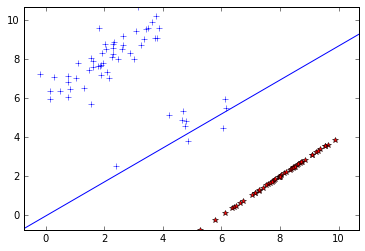

In [8]:
X,R,N1,N2 = gen_data_gauss(N11=50, N12=10, N2=50)
clf = linear_model.SGDClassifier(penalty='l1', loss='log', n_iter=1000, alpha=0.05)
W=clf.fit(X, R)
draw_points(X,N1,[np.min(X), np.max(X)],[np.min(X), np.max(X)],W=[-W.intercept_[0],-W.coef_[0][0],1])

### Support Vector Machines

In [9]:
iris = datasets.load_iris()
X = iris.data[:,:2]
R = iris.target
svc = svm.SVC(kernel='linear').fit(X, R)

### Tensorflow Binary Classification

In [10]:
# https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/multilayer_perceptron.ipynb
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split

/home/cagatay/software/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
# Generate tain and test data
X, Y = make_classification(n_samples=50000, n_features=10, n_informative=8, 
                    n_redundant=0, n_clusters_per_class=2)
Y = np.array([Y, -(Y-1)]).T  # The model currently needs one column for each class
X, X_test, Y, Y_test = train_test_split(X, Y)

In [13]:
# Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 100
display_step = 1

# Network Parameters
n_hidden_1 = 10 # 1st layer number of features
n_hidden_2 = 10 # 2nd layer number of features
n_input = 10 # Number of feature
n_classes = 2 # Number of classes to predict

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [14]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [15]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(X)/batch_size)
        X_batches = np.array_split(X, total_batch)
        Y_batches = np.array_split(Y, total_batch)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = X_batches[i], Y_batches[i]
            # batch_y.shape = (batch_y.shape[0], 1)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch: " +  str(epoch+1) + " cost=" + str(avg_cost))
    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:" +  str(accuracy.eval({x: X_test, y: Y_test})))
    global result 
    result = tf.argmax(pred, 1).eval({x: X_test, y: Y_test})

Epoch: 1 cost=3.82966477871
Epoch: 2 cost=0.847286717097
Epoch: 3 cost=0.531762905518
Epoch: 4 cost=0.445342092276
Epoch: 5 cost=0.394749931137
Epoch: 6 cost=0.358908666889
Epoch: 7 cost=0.33006555601
Epoch: 8 cost=0.304661373854
Epoch: 9 cost=0.282781939348
Epoch: 10 cost=0.264598283052
Optimization Finished!
Accuracy:0.88768
